# Cross-frequency coupling *for the practicing neuroscientist*

To assess whether different frequency rhythms interact in the LFP recording, we implement a measure to calculate CFC. The idea of CFC analysis is to determine whether a relation exists between the phase of a low-frequency signal and the envelope or amplitude of a high-frequency signal. In general, computing CFC involves three steps. Each step contains important questions and encompasses entire fields of study. Our goal in this section is to move quickly forward and produce a procedure we can employ, investigate, and criticize. Continued study of CFC—and the associated nuances of each step—is an active area of ongoing research.

### CFC analysis steps

* Filter the data into high- and low-frequency bands.

* Extract the amplitude and phase from the filtered signals.

* Determine if the phase and amplitude are related.

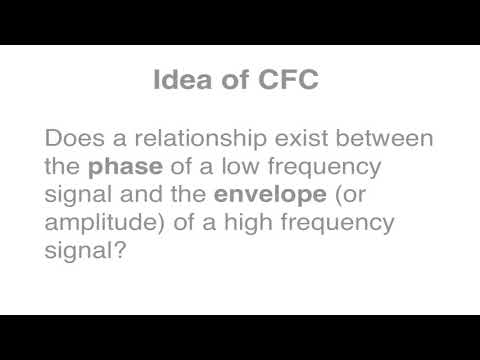

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('JjOcJy4dVzE')

## Step 1. Filter the Data into High- and Low-Frequency Bands.

The first step in the CFC analysis is to filter the data into two frequency bands of interest. The choice is not arbitrary: the separate frequency bands are motivated by initial spectral analysis of the LFP data. In this case, we choose the low-frequency band as 5–7 Hz, consistent with the largest peak in the spectrum, and the high-frequency band as 80–120 Hz, consistent with the second-largest broadband peak. To consider alternative frequency bands, the same analysis steps would apply.

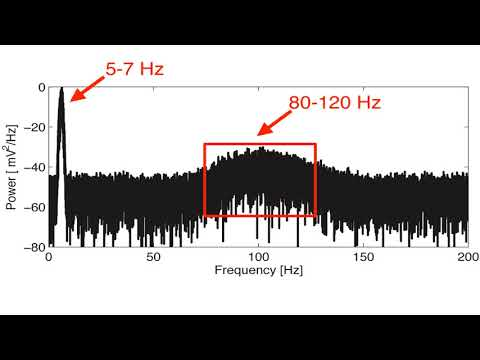

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('WL_nFRBHqLU')

There are many options to perform the filtering. To do so requires us to design a filter that ideally extracts the frequency bands of interest without distorting the results. Here, we apply a finite impulse response (FIR) filter. In Python,

In [3]:
import scipy.io as sio
mat = sio.loadmat('LFP-1.mat')      # Load the data.
t = mat['t'][0]                     # Get the time axis.
LFP = mat['LFP'][0]                 # Get the LFP data.

In [4]:
dt = t[2]-t[1];                     # Define the sampling interval.
Fs = 1/dt;                          # Define the sampling frequency.
fNQ = Fs/2;                         # Define the Nyquist frequency.

For the **low-frequency** interval:

In [5]:
from scipy import signal
Wn = [5,7];                         # Set the passband [5-7] Hz,
n = 100;                            # ... and filter order,
                                    # ... build bandpass filter.
b = signal.firwin(n,Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(b,1,LFP);     # ... and apply filter.

For the **high-frequency** interval:

In [6]:
from scipy import signal
Wn = [80,120];                      # Set the passband [80-120] Hz,
n = 100;                            # ... and filter order,
                                    # ... build bandpass filter.
b = signal.firwin(n,Wn, nyq=fNQ, pass_zero=False, window='hamming');
Vhi = signal.filtfilt(b,1,LFP);     # ... and apply filter.

For each frequency band, we specify a frequency interval of interest by defining the low- and high-cutoff frequencies in the variable `Wn`. In this way, we specify the passband of the filter. We then set the filter order (`n`) and design the filter using the Python function `signal.firwin` from the `scipy` [package](https://scipy.org/). Finally, we apply the filter using the Python function `signal.filtfilt`, which performs zero-phase filtering by applying the filter in both the forward and reverse directions.  We note that the filtering procedure is nearly the same in both frequency bands; the only change is the specification of the frequency interval of interest.

To understand the impact of this filtering operation on the LFP, let’s plot the results. More specifically, let's plot the original signal, and the signal filtered in the low- and high-frequency bands, for a 2 s interval of time:

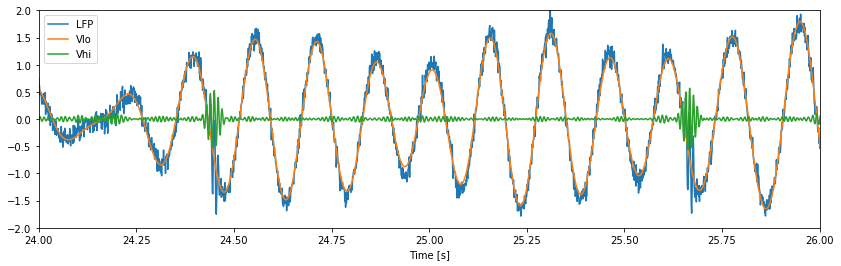

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))         # ... with a specific size.
plt.plot(t,LFP)                     # Plot the original data vs time.
plt.plot(t,Vlo)                     # Plot the low-frequency filtered data vs time.
plt.plot(t,Vhi)                     # Plot the high-frequency filtered data vs time.
plt.xlabel('Time [s]')
plt.xlim([24, 26]);                 # Choose a 2 s interval to examine
plt.ylim([-2, 2]);
plt.legend(['LFP', 'Vlo', 'Vhi']);  # Add a legend.

As expected, the low-frequency band (orange) captures the large-amplitude rhythm dominating the LFP signal, while the higher-frequency band (green) isolates the brief bursts of faster activity.

# Step 2. Extract the Amplitude and Phase from Filtered Signals.

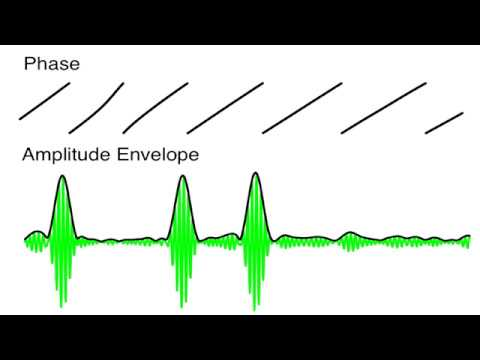

In [8]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('QiRuBvbCQt4')

The next step in the CFC procedure is to extract the *phase* of the low-frequency signal and the amplitude envelope (or simply, *amplitude*) of the high-frequency signal. To compute CFC, we then compare these two signals, i.e., we compare the phase of the low-frequency activity and the amplitude envelope of the high-frequency activity. How do we actually extract the phase and amplitude signals from the data? There are a variety of options to do so, and we choose here to employ the **analytic signal approach**, which allows us to estimate the instantaneous phase and amplitude envelope of the LFP.

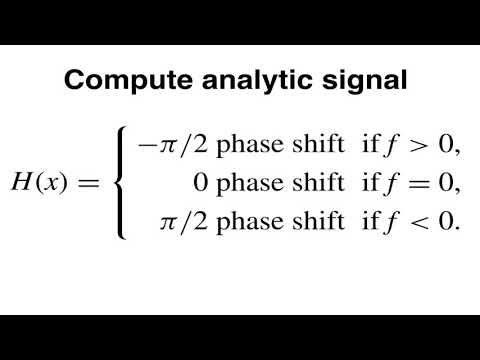

In [9]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Ir8Gf550S3o')

The first step in computing the analytic signal is to compute the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform). We begin with some notation. Define $x$ as a narrowband signal (i.e., a signal with most of its energy concentrated in a narrow frequency range, e.g., the low- or high-frequency band filtered signals we've created). Then the Hilbert transform of $x$, let’s call it $y$, is

$$y = H(x).$$

It’s perhaps more intuitive to consider the effect of the Hilbert Transform on the frequencies
$f$ of $x$,

$$
\begin{equation}
    H(x)=
    \begin{cases}
      -\pi/2 & \text{ phase shift if } f>0 \\
      0 & \text{ phase shift if } f=0 \\
      \pi/2 & \text{ phase shift if } f<0 \\
    \end{cases}
  \end{equation}
$$

* To summarize:  The Hilbert transform $H(x)$ of the signal $x$ produces a phase shift of $\pm 90$ degrees for $\mp$ frequencies of $x$.

The Hilbert Transform can also be described in the time domain, although its representation is hardly intuitive (see the appendix at the end of this chapter). Then the analytic signal $z$ is

$$ z = x + i y = x + i H(x). $$

The effect of the Hilbert transform is to remove negative frequencies from $z$. As it stands,
this is not obvious. To get a sense for why this is so, let’s consider a simple example.

# What Does the Hilbert Transform Do?

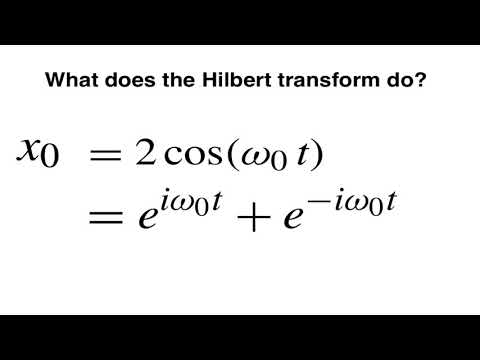

In [10]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('-CjnFEOopfw')

Let $x_0$ be a sinusoid at frequency $f_0$, 

$$ x_0 = 2 \cos(2 \pi f_0 t) = 2 \cos(\omega_0 t),$$

where to simplify notation we have defined $\omega_0 = 2 \pi f_0$. We know from [Euler’s formula](https://en.wikipedia.org/wiki/Euler%27s_formula) that

$$x_0 = e^{i \omega_0 t} + e^{-i \omega_0 t}.$$

The real variable $x_0$ possesses both a positive and a negative frequency component (i.e., $\omega_0$ and $-\omega_0$). So, the spectrum has two peaks:

<img src="NDx_M05_V9_spectrum.png" alt="Drawing" style="width: 500px;"/>

For real signals, which include nearly all recordings of brain activity, the negative frequency component is redundant, and we usually ignore it. However, the negative frequency component still remains. By definition, the effect of the Hilbert transform is to induce a phase shift. For positive frequencies, the phase shift is  $-\pi/2$. We can produce this phase shift by multiplying the positive frequency part of the signal by $-i$.

**Q: Why does a phase shift of  $-\pi/2$ correspond to multiplication by $-i$?**

**A:** Consider the complex exponential $e^{i \omega_0 t}$, which consists of only a positive frequency component ($\omega_0$). This signal shifted in phase by $-\pi/2$ corresponds to the new signal $e^{i \omega_0 t - \pi / 2}$, which simplifies to $$e^{i \omega_0 t} e^{-i\pi/2} = e^{i\omega_0 t}\bigg(\cos(\pi/2) - i \sin(\pi/2)\bigg) = e^{i\omega_0 t} (-i).$$